## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp "/content/gdrive/MyDrive/xview_recognition.zip" "/content/"

In [3]:
!unzip "/content/xview_recognition.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: xview_train/Shipping container/778dd2fe-ad63-4889-9380-8a7acba75977.tif  
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4d5ce506cb9c

In [4]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [5]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [6]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 55.3 MB/s eta 0:00:00


In [7]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, underrepresented_class, data_augmentation=False, do_shuffle=False):
    if data_augmentation:
        # Define data augmentation parameters
        data_gen = ImageDataGenerator(
             rotation_range=20,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,
             fill_mode='nearest'
        )

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Apply data augmentation only to underrepresented class if enabled
                if data_augmentation and obj.category == underrepresented_class:
                    img = data_gen.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            if images:
                images = np.array(images).astype(np.float32)
                labels = np.array(labels).astype(np.float32)
                yield images, labels
            else:
                # Handle case where there are no more images
                break


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [9]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [10]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [11]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TerminateOnNaN


# Load the pre-trained EfficientNetB7 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
model.add(Dropout(0.6))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
model.add(Dropout(0.6))
model.add(Dense(len(categories), activation='softmax'))

model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [13]:
# Compile the model with a lower learning rate
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
# Generate the list of objects from annotations
# Definizione della classe sottorappresentata
underrepresented_class = 'Helicopter'
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

# Filtraggio degli oggetti nel set di addestramento che appartengono alla classe sottorappresentata
objs_train_underrepresented = [(filename, obj) for filename, obj in objs_train if obj.category == underrepresented_class]

objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
# Definizione del generatore di immagini per il training
train_generator = generator_images(objs_train, batch_size, None ,data_augmentation=False, do_shuffle=True)

# Definizione del generatore di immagini per la data augmentation solo per la classe sottorappresentata
train_generator_underrepresented = generator_images(objs_train_underrepresented, batch_size, underrepresented_class ,data_augmentation=True, do_shuffle=True)

valid_generator = generator_images(objs_valid, batch_size, None ,data_augmentation=False, do_shuffle=False)

In [16]:
def combined_generator(gen1, gen2):
    while True:
        batch_x1, batch_y1 = next(gen1)
        batch_x2, batch_y2 = next(gen2)
        yield np.concatenate((batch_x1, batch_x2)), np.concatenate((batch_y1, batch_y2))

In [17]:
import math
import numpy as np
print('Training model')
epochs = 15
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(combined_generator(train_generator,train_generator_underrepresented), steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/15
602/602 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.6606
Epoch 1: val_accuracy improved from -inf to 0.61413, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 394s 621ms/step - loss: 1.6641 - accuracy: 0.6606 - val_loss: 1.5017 - val_accuracy: 0.6141 - lr: 0.0010
Epoch 2/15
602/602 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.7686
Epoch 2: val_accuracy improved from 0.61413 to 0.63891, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 339s 564ms/step - loss: 0.9824 - accuracy: 0.7686 - val_loss: 1.2926 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 3/15
602/602 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.8026
Epoch 3: val_accuracy improved from 0.63891 to 0.67166, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 344s 571ms/step - loss: 0.7935 - accuracy: 0.8026 - val_loss: 1.1710 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 4/15
602/602 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.8186
Epoch 4: val_accuracy improved from 0.67166 to 0.71890, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 351s 584ms/step - loss: 0.7038 - accuracy: 0.8186 - val_loss: 1.0093 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 5/15
602/602 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.8309
Epoch 5: val_accuracy did not improve from 0.71890
602/602 [==============================] - 341s 567ms/step - loss: 0.6409 - accuracy: 0.8309 - val_loss: 1.0956 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 6/15
602/602 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.8475
Epoch 6: val_accuracy improved from 0.71890 to 0.72732, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 351s 584ms/step - loss: 0.5953 - accuracy: 0.8475 - val_loss: 0.9856 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/15
602/602 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.8537
Epoch 7: val_accuracy improved from 0.72732 to 0.75164, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 348s 579ms/step - loss: 0.5642 - accuracy: 0.8537 - val_loss: 0.8625 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 8/15
602/602 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.8603
Epoch 8: val_accuracy did not improve from 0.75164
602/602 [==============================] - 348s 578ms/step - loss: 0.5344 - accuracy: 0.8603 - val_loss: 1.0139 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 9/15
602/602 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.8667
Epoch 9: val_accuracy improved from 0.75164 to 0.76286, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 340s 565ms/step - loss: 0.5157 - accuracy: 0.8667 - val_loss: 0.8498 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 10/15
602/602 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8765
Epoch 10: val_accuracy did not improve from 0.76286
602/602 [==============================] - 350s 581ms/step - loss: 0.4839 - accuracy: 0.8765 - val_loss: 0.9610 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 11/15
602/602 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.8810
Epoch 11: val_accuracy did not improve from 0.76286
602/602 [==============================] - 349s 580ms/step - loss: 0.4678 - accuracy: 0.8810 - val_loss: 0.8954 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 12/15
602/602 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8889
Epoch 12: val_accuracy did not improve from 0.76286
602/602 [==============================] - 340s 565ms/step - loss: 0.4490 - accuracy: 0.8889 - val_loss: 0.91

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 350s 581ms/step - loss: 0.3524 - accuracy: 0.9164 - val_loss: 0.8476 - val_accuracy: 0.7680 - lr: 2.0000e-04
Epoch 14/15
602/602 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.9274
Epoch 14: val_accuracy improved from 0.76801 to 0.77643, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 351s 583ms/step - loss: 0.3067 - accuracy: 0.9274 - val_loss: 0.8524 - val_accuracy: 0.7764 - lr: 2.0000e-04
Epoch 15/15
602/602 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9367
Epoch 15: val_accuracy did not improve from 0.77643
602/602 [==============================] - 340s 566ms/step - loss: 0.2700 - accuracy: 0.9367 - val_loss: 0.8409 - val_accuracy: 0.7736 - lr: 2.0000e-04
Best validation model: epoch 14  - val_accuracy 0.7764265537261963


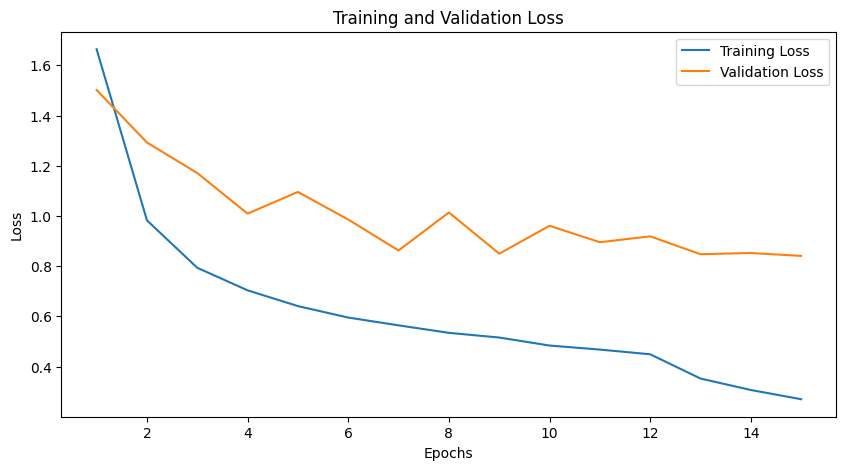

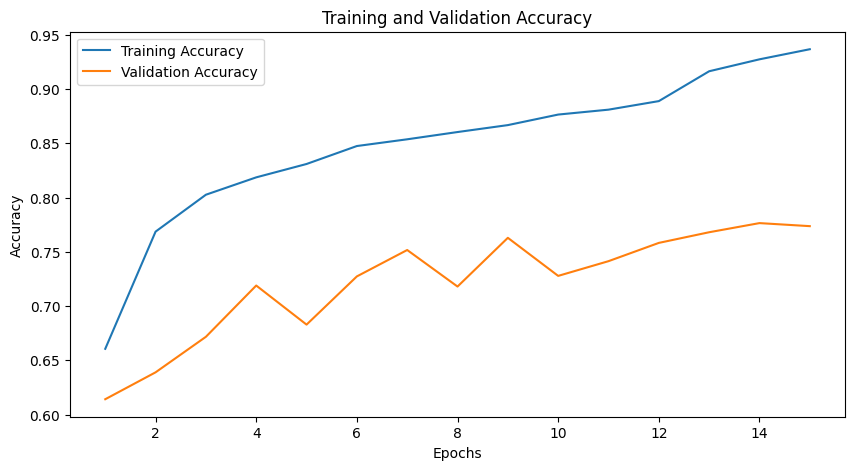

In [18]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [19]:


import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [20]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [21]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 41ms/step


<ipython-input-8-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


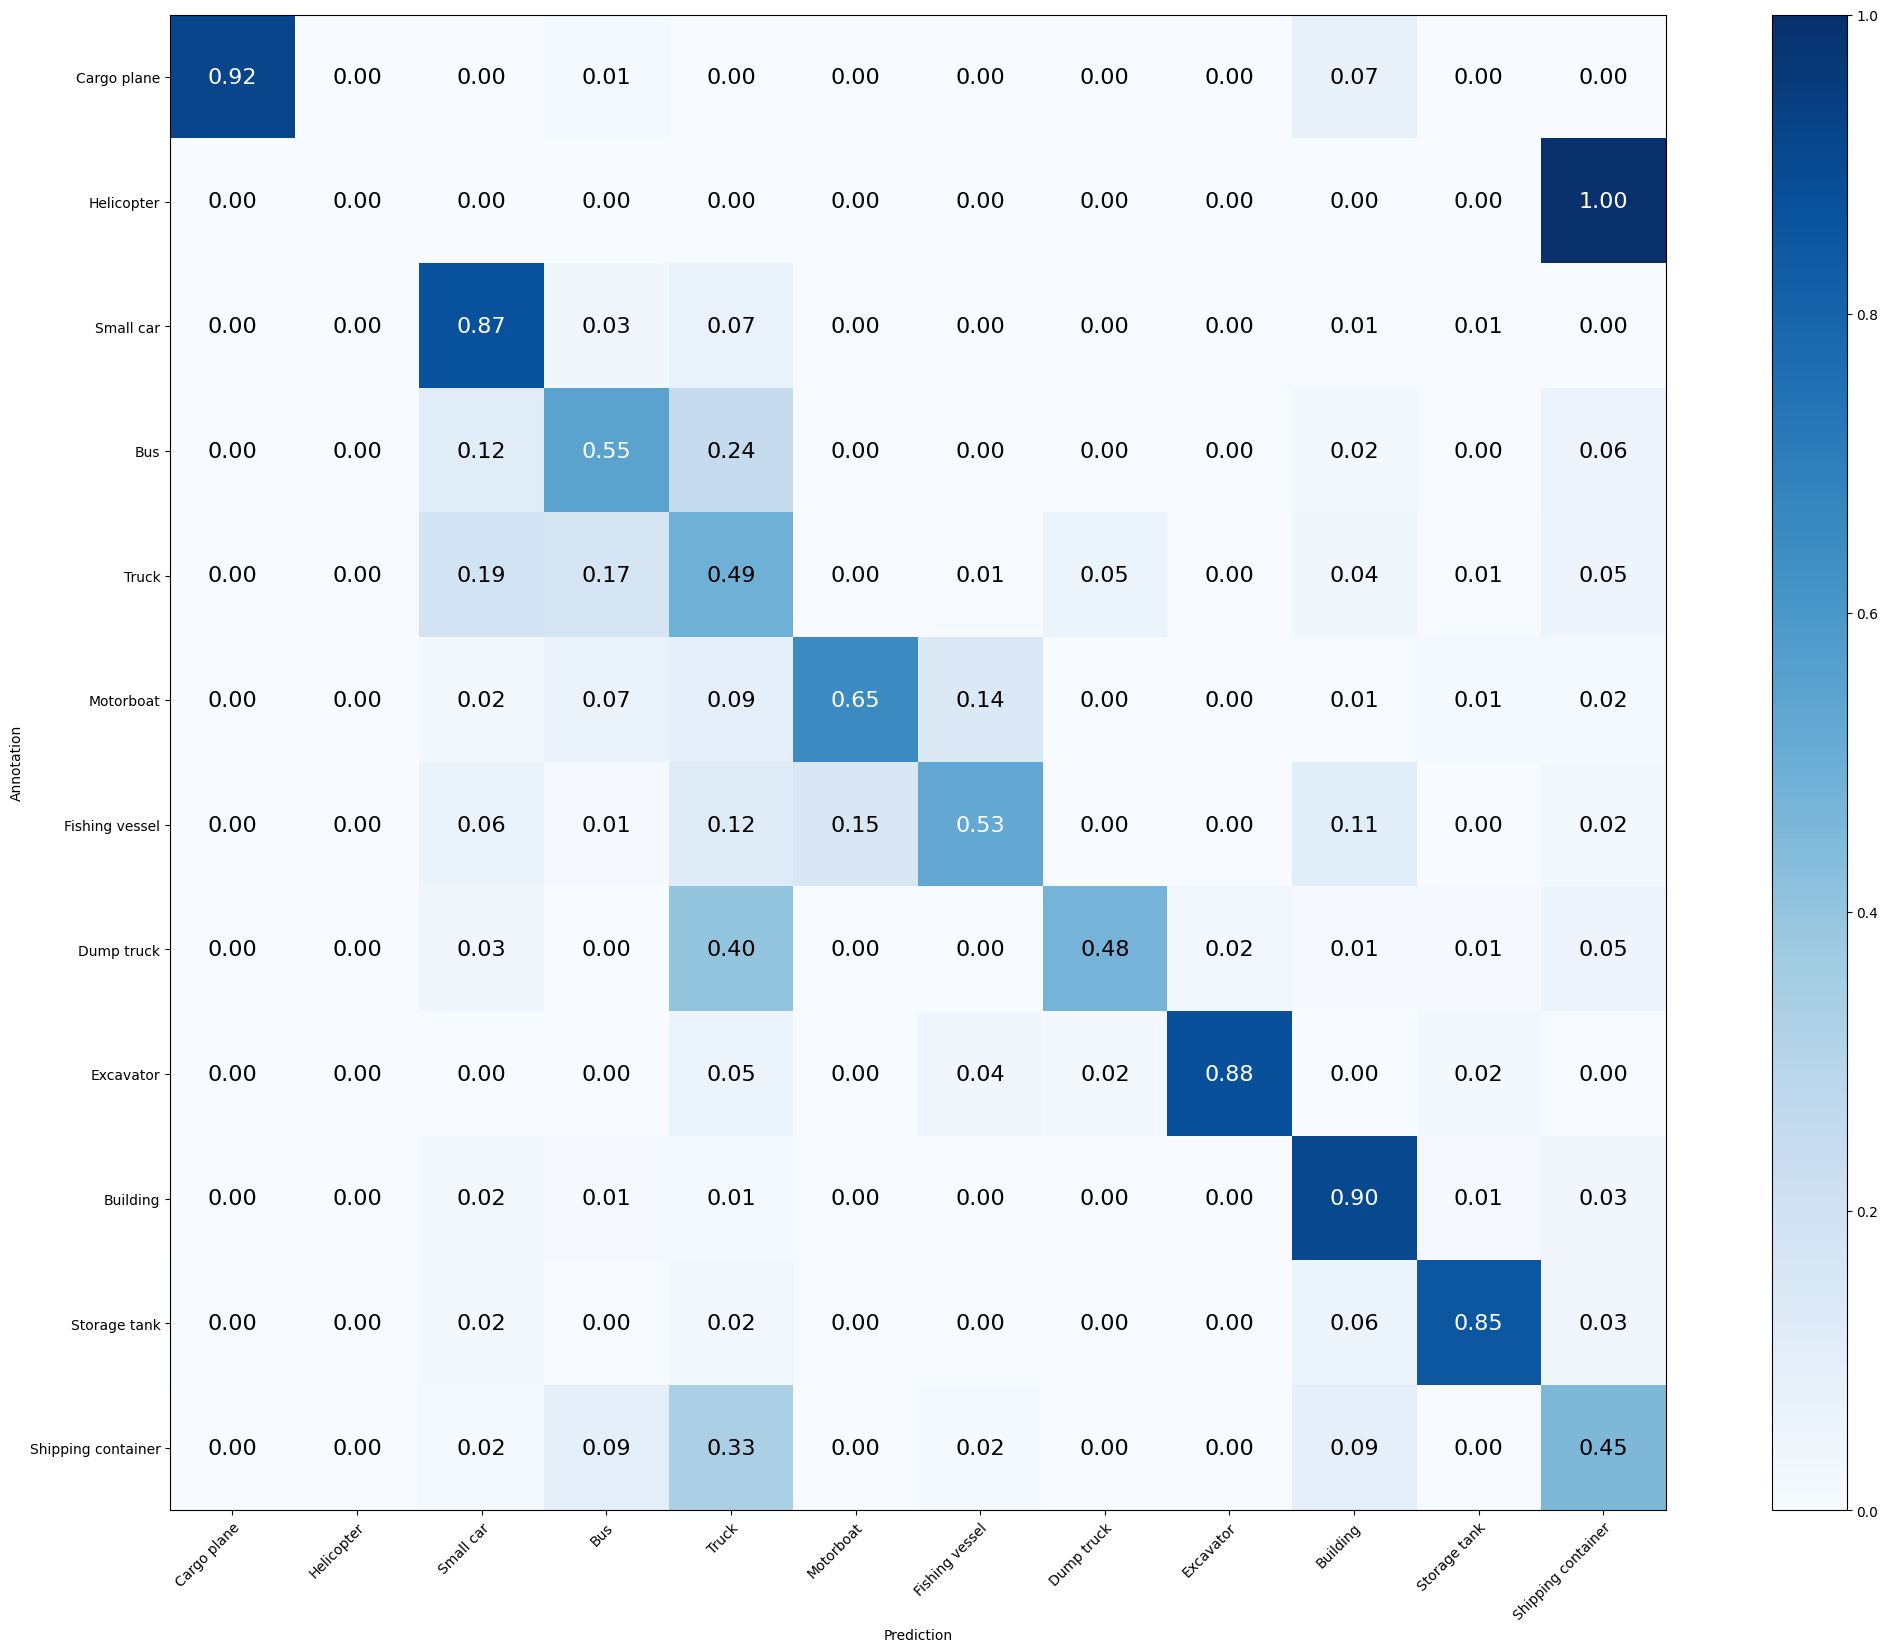

In [22]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [23]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 73.017%
Mean Recall: 63.061%
Mean Precision: 65.044%
> Cargo plane: Recall: 91.566% Precision: 97.436% Specificity: 99.922% Dice: 94.410%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 87.474% Precision: 78.022% Specificity: 94.413% Dice: 82.478%
> Bus: Recall: 54.959% Precision: 55.417% Specificity: 95.529% Dice: 55.187%
> Truck: Recall: 49.180% Precision: 39.894% Specificity: 90.300% Dice: 44.053%
> Motorboat: Recall: 64.975% Precision: 93.431% Specificity: 99.197% Dice: 76.647%
> Fishing vessel: Recall: 52.688% Precision: 44.545% Specificity: 97.600% Dice: 48.276%
> Dump truck: Recall: 47.541% Precision: 73.418% Specificity: 99.164% Dice: 57.711%
> Excavator: Recall: 87.719% Precision: 87.719% Specificity: 99.728% Dice: 87.719%
> Building: Recall: 90.406% Precision: 89.091% Specificity: 97.133% Dice: 89.744%
> Storage tank: Recall: 84.774% Precision: 91.556% Specificity: 99.206% Dice: 88.034%
> Shipping container

In [ ]:
!cp "/content/model.hdf5" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_test.json" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_train.json" "/content/gdrive/MyDrive/Nino/"

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.